# Cow + Univ3 DataPipeline

The goal of this notebook is to show and explain how to create a decentralized data pipeline powered by Cow Subgraphs with DataStreams. DataStreams functions as a GraphQL query manager for Subgraphs and allows one to compose queries together into a fully replicatable data pipeline. Data comes from the following sources:
CoW Subgraph - https://thegraph.com/hosted-service/subgraph/cowprotocol/cow
Univ3 Subgraph - https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum
Dune Solver Names Query link - https://dune.com/queries/1941061


### Installation Notes
If you haven't already, you can install DataStreams with the command `!pip install git+https://github.com/Evan-Kim2028/DataStreams.git` in a new cell. Exclude the `!` if you are installing in a virtual environment or terminal. DataStreams requires Python 3.10 or greater too. Finally we use polars to perform merges and column mutations. You can install polars with `!pip install polars`.

### Process
First we query the CoW trade schemas twice for WETH/USDC. Then we query the CoW schema for settlement info. Finally we download the Dune Solver names query and merge it with the CoW data. We then perform some column mutations with polars to get the final data.

For Univ3 data, we query the swaps schema for the USDC/WETH .05% and .3% fee pools. Then we merge the CoW trades data and Univ3 Swaps data for transactions that occur at the same timestamp. We add decimal places for the amounts and calculate marginal swap execution prices for comparison.

### Setup Jupyter Environment

In [1]:
from datastreams.datastream import Streamer

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

# These commands enlarge the column size of the dataframe so things like 0x... are not truncated
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

### Cowswap Trades

In [2]:
# instantiate Streamer class. Note that we need two separate streamer classes, otherwise the queries will be overwritten. 
cow_ds1 = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')
cow_ds2 = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')

In [3]:
# DEFINE TIMESTAMP HERE. Timstamp is used for replication quality assurance purposes.
timestamp = 1700000000

# define ethereum token addresses here to be used in cowswap trades query filter
weth_addr = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
usdc_addr = "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"

# we set a fixed query size number. The Cow settlements and Uniswap swaps query are multiples larger than this initial query size.
query_size = 250

#Filter size - We filter trades out that are smaller than $1000 USD size
filter_usd = 10000

In [4]:
token_addr_list = [weth_addr, usdc_addr]

In [5]:
# We need to make two queries to the cow schema to get all the trades that match weth/usdc and usdc/weth.
trades_weth_usdc_fp = cow_ds1.queryDict.get('trades')
trades_usdc_weth_fp = cow_ds2.queryDict.get('trades')

# trades query path that gets token a -> token b trades
trades_weth_usdc_qp = trades_weth_usdc_fp(
    first=query_size,
    orderBy='timestamp',
    orderDirection='desc',
    where = {
    'timestamp_lt': timestamp, 
    'buyAmountUsd_gt': filter_usd, 
    'sellAmountUsd_gt': filter_usd, 
    "sellToken_in": token_addr_list, 
    "buyToken_in": token_addr_list
    }
)

# trades query path that gets token b -> token a trades
trades_usdc_weth_qp = trades_usdc_weth_fp(
    first=query_size,
    orderBy='timestamp',
    orderDirection='desc',
    where = {
    'timestamp_lt': timestamp, 
    'buyAmountUsd_gt': filter_usd, 
    'sellAmountUsd_gt': filter_usd, 
    "sellToken_in": token_addr_list, 
    "buyToken_in": token_addr_list
    }
)

# run query
trades_weth_usdc_df = cow_ds1.runQuery(trades_weth_usdc_qp)
trades_usdc_weth_df = cow_ds2.runQuery(trades_usdc_weth_qp)

FIELD - trades
FIELD - trades


In [6]:
# combine the trades queries together
trades_df = pd.concat([trades_weth_usdc_df, trades_usdc_weth_df])

In [7]:
print(f'query returned {len(trades_df)} rows')

query returned 20000 rows


In [8]:
# get unique values in trades_df column to verify the query results.
trades_df['trades_buyToken_id'].unique()

array(['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
       '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'], dtype=object)

In [9]:
# replace the above values with symbols
trades_df['trades_buyToken_id'] = trades_df['trades_buyToken_id'].replace(weth_addr, 'WETH')
trades_df['trades_buyToken_id'] = trades_df['trades_buyToken_id'].replace(usdc_addr, 'USDC')

trades_df['trades_sellToken_id'] = trades_df['trades_sellToken_id'].replace(weth_addr, 'WETH')
trades_df['trades_sellToken_id'] = trades_df['trades_sellToken_id'].replace(usdc_addr, 'USDC')

### Cowswap Trades-Settlement Merge

In [10]:
# get a query field path from the query dictionary which is automatically populated in the Streamer object
settlements_fp = cow_ds1.queryDict.get('settlements')

# add parameters to the settlements_qp.
settlements_qp = settlements_fp(
    first=query_size * 5,
    orderBy='firstTradeTimestamp',
    orderDirection='desc',
    where = {'firstTradeTimestamp_lt': timestamp} 
    )

# run query
settlements_df = cow_ds1.runQuery(settlements_qp)

FIELD - settlements


In [11]:
settlements_df.size

250000

In [12]:
trades_df.dtypes

trades_id                object
trades_timestamp          int64
trades_gasPrice           int64
trades_feeAmount          int64
trades_txHash            object
trades_settlement_id     object
trades_buyAmount         object
trades_sellAmount        object
trades_sellToken_id      object
trades_buyToken_id       object
trades_order_id          object
trades_buyAmountEth     float64
trades_sellAmountEth    float64
trades_buyAmountUsd     float64
trades_sellAmountUsd    float64
endpoint                 object
dtype: object

In [13]:
# enforce trades_df column types. This is necessary because the data types are not enforced by pandas dataframes. Types are enforced as a Polars dataframe because of the columnar storage method.
trades_df['trades_buyAmount'] = trades_df['trades_buyAmount'].astype('float64')
trades_df['trades_sellAmount'] = trades_df['trades_sellAmount'].astype('float64')
trades_df['trades_buyAmountUsd'] = trades_df['trades_buyAmountUsd'].astype('float64')
trades_df['trades_sellAmountUsd'] = trades_df['trades_sellAmountUsd'].astype('float64')
trades_df['trades_timestamp'] = trades_df['trades_timestamp'].astype('int64')
trades_df['trades_buyToken_id'] = trades_df['trades_buyToken_id'].astype('str')
trades_df['trades_sellToken_id'] = trades_df['trades_sellToken_id'].astype('str')

In [14]:
# convert dfs into a dictionaries
settlement_dict = settlements_df.to_dict('records')
trades_dict = trades_df.to_dict('records')

In [15]:
# convert dictionaries into polars dataframes
settlement_pl = pl.from_dicts(settlement_dict)
trades_pl = pl.from_dicts(trades_dict)

In [16]:
# merge trades and settlement dataframes on the settlement transaction hash
cow_trades_pl = trades_pl.join(other=settlement_pl, left_on='trades_settlement_id', right_on='settlements_txHash', how='inner')

In [17]:
cow_trades_pl.shape

(5162, 20)

In [18]:
cow_trades_pl.head(5)

trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_order_id,trades_buyAmountEth,trades_sellAmountEth,trades_buyAmountUsd,trades_sellAmountUsd,endpoint,settlements_id,settlements_firstTradeTimestamp,settlements_solver_id,endpoint_right
str,i64,i64,i64,str,str,f64,f64,str,str,str,f64,f64,f64,f64,str,str,i64,str,str
"""0xf8fb3b909ec2...",1677169187,51230451365,0,"""0x4cf8089ef690...","""0x4cf8089ef690...",4.9451e19,8.1640e10,"""USDC""","""WETH""","""0xf8fb3b909ec2...",49.45069,49.350676,81804.969143,81639.5189,"""cow""","""0x4cf8089ef690...",1677169187,"""0x149d0f928233...","""cow"""
"""0xf8fb3b909ec2...",1677169187,51230451365,0,"""0x4cf8089ef690...","""0x4cf8089ef690...",4.9451e19,8.1640e10,"""USDC""","""WETH""","""0xf8fb3b909ec2...",49.45069,49.350676,81804.969143,81639.5189,"""cow""","""0x4cf8089ef690...",1677169187,"""0x149d0f928233...","""cow"""
"""0xfccda569ab49...",1677166991,56627397633,0,"""0xdb3e51004284...","""0xdb3e51004284...",8.1640e10,4.9330e19,"""WETH""","""USDC""","""0xfccda569ab49...",49.275525,49.329808,81639.5189,81729.454824,"""cow""","""0xdb3e51004284...",1677166991,"""0xa21740833858...","""cow"""
"""0xfccda569ab49...",1677166991,56627397633,0,"""0xdb3e51004284...","""0xdb3e51004284...",8.1640e10,4.9330e19,"""WETH""","""USDC""","""0xfccda569ab49...",49.275525,49.329808,81639.5189,81729.454824,"""cow""","""0xdb3e51004284...",1677166991,"""0xa21740833858...","""cow"""
"""0xeef4ef1b32d2...",1677166055,65598623073,24323911,"""0xe62ee918ac40...","""0xe62ee918ac40...",1.5000e19,2.4895e10,"""USDC""","""WETH""","""0xeef4ef1b32d2...",15.0,15.040685,24828.120542,24895.46251,"""cow""","""0xe62ee918ac40...",1677166055,"""0xda869be4adea...","""cow"""


In [19]:
# get unique values in cow_trades_pl trades_sellToken_id column
cow_trades_pl['trades_sellToken_id'].unique()

trades_sellToken_id
str
"""WETH"""
"""USDC"""


### Cowswap Trades-Solver Merge

In [20]:
solvers = pd.read_csv('data/cowv2_solvers.csv') # load in pandas instead of polars. Having trouble replacing \ symbol in polars

In [21]:
# rename address to settlements_solver_id in pandas
solvers = solvers.rename(columns={"address": "settlements_solver_id"})

In [22]:
# NOTE - dune formats addresses as /x... need to convert '/' to '0'
solvers['settlements_solver_id'] = solvers['settlements_solver_id'].str.replace('\\', '0', regex=False)

In [23]:
# turn solvers into a dictionary
solvers_dict = solvers.to_dict('records')

# convert dict to polars
solvers_pl = pl.from_dicts(solvers_dict)

In [24]:
# inner join solvers_pl on total_settlement_tokens_pl
cow_complete_pl = cow_trades_pl.join(solvers_pl, on="settlements_solver_id", how="inner")

In [25]:
# drop endpoint_right column from total_settlement_tokens_solvers
cow_complete_pl = cow_complete_pl.drop('endpoint_right')

In [26]:
cow_complete_pl.shape

(5026, 22)

#### Basic Agg

In [27]:
# filter by "prod" environments
filter_df = cow_complete_pl.filter(pl.col("environment") == "prod")

In [28]:
# filter by "prod" environments
filter_df = cow_complete_pl.filter(pl.col("environment") == "prod")

In [29]:
filter_df.shape

(4976, 22)

In [30]:
# group filter_df by solver name. Check solver count
grouped_df = filter_df.groupby("name").agg(
    pl.count("trades_id").alias("total_trades")).sort("total_trades", reverse=True)


In [31]:
grouped_df

name,total_trades
str,u32
"""PLM""",1794
"""Otex""",1498
"""Laertes""",740
"""Quasilabs""",566
"""Gnosis_1inch""",216
"""Seasolver""",54
"""Gnosis_0x""",48
"""DexCowAgg""",18
"""Baseline""",14


### Uniswap V3 Swaps

In [32]:
# instantiate Streamer object. 
# Note - unlike the cow queries, univ3 does not require multiple streamer instantations because the swaps field path is reset each iteration. 
# If the Cow queries were updated to use the same method, we could use the same streamer object for all queries.
univ3_ds = Streamer('https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum')

In [33]:
# get a query field path from the query dictionary which is automatically populated in the Streamer object
swaps_fp = univ3_ds.queryDict.get('swaps')

In [34]:
weth_usdc_list = [
    "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", # usdc/weth .05%
    "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8" #usdc/weth .3%
]

In [35]:
swaps_df_list = []

In [36]:
# for loop over the LP list to get the swap data
for lp in weth_usdc_list:
    # add parameters to the query_path
    swaps_qp = swaps_fp(
        first=query_size * 5,
        orderBy='timestamp',
        orderDirection='desc',
        where = {'timestamp_lt': timestamp, 'amountInUSD_gt': filter_usd, 'amountOutUSD_gt': filter_usd, 'pool': lp} 
        )

    # run query
    swaps_df = univ3_ds.runQuery(swaps_qp)
    swaps_df_list.append(swaps_df)

FIELD - swaps
FIELD - swaps


In [37]:
# concat swaps_df_list into a single dataframe.
swaps_df = pd.concat(swaps_df_list)

In [38]:
# replace the pool addresses with LP pool names with fees
swaps_df['swaps_pool_id'] = swaps_df['swaps_pool_id'].replace(weth_usdc_list[0], 'USDC_WETH .05%')
swaps_df['swaps_pool_id'] = swaps_df['swaps_pool_id'].replace(weth_usdc_list[1], 'USDC_WETH .3%')

# replace token addresses with symbols
swaps_df['swaps_tokenIn_id'] = swaps_df['swaps_tokenIn_id'].replace(usdc_addr, 'USDC')
swaps_df['swaps_tokenIn_id'] = swaps_df['swaps_tokenIn_id'].replace(weth_addr, 'WETH')
swaps_df['swaps_tokenOut_id'] = swaps_df['swaps_tokenOut_id'].replace(usdc_addr, 'USDC')
swaps_df['swaps_tokenOut_id'] = swaps_df['swaps_tokenOut_id'].replace(weth_addr, 'WETH')

In [39]:
print(f'query returned {len(swaps_df)} rows\n swaps_df columns are {swaps_df.columns}')

query returned 200000 rows
 swaps_df columns are Index(['swaps_id', 'swaps_hash', 'swaps_logIndex', 'swaps_protocol_id',
       'swaps_to', 'swaps_from', 'swaps_blockNumber', 'swaps_timestamp',
       'swaps_tokenIn_id', 'swaps_amountIn', 'swaps_amountInUSD',
       'swaps_tokenOut_id', 'swaps_amountOut', 'swaps_amountOutUSD',
       'swaps_pool_id', 'endpoint'],
      dtype='object')


In [40]:
# convert swaps_df to pl
swaps_dict = swaps_df.to_dict('records')
swaps_pl = pl.from_dicts(swaps_dict)

### Merge Cow and Univ3

In [41]:
# merge trades and swaps on timestamp value. We use outer join because we want to keep all trades and swaps data and backfill swap values
cow_uni_outer_pl = cow_complete_pl.join(other=swaps_pl, left_on='trades_timestamp', right_on='swaps_timestamp', how='outer')

In [42]:
# This truncated dataframe isn't being used right now
cow_uni_trunc_pl = cow_uni_outer_pl[[
    'trades_timestamp', 
    'trades_txHash',
    'trades_feeAmount',
    'trades_sellToken_id', 
    'trades_buyToken_id', 
    'trades_buyAmount',
    'trades_sellAmount',
    # 'trades_sellAmountUsd', 
    # 'trades_buyAmountUsd', 
    'name',
    'environment',
    'swaps_pool_id', 
    'swaps_tokenIn_id', 
    'swaps_tokenOut_id',
    'swaps_amountIn',
    'swaps_amountOut',  
    # 'swaps_amountInUSD',
    # 'swaps_amountOutUSD',
    'swaps_blockNumber'
    ]]

In [43]:
#check pl dataframe size
cow_uni_outer_pl.shape

(204946, 37)

### Chainlink

In [44]:
# load streamer class
chain_ds = Streamer('https://api.thegraph.com/subgraphs/name/openpredict/chainlink-prices-subgraph')

In [45]:
chain_price_feed = "ETH/USD"

In [46]:
# get a query field path from the query dictionary which is automatically populated in the Streamer object
chain_fp = chain_ds.queryDict.get('prices')

# add parameters to the settlements_qp.
chain_qp = chain_fp(
    first=query_size * 5,
    orderBy='timestamp',
    orderDirection='desc',
    where = {'timestamp_lt': timestamp, 'assetPair': chain_price_feed}
    )

# run query
chain_df = chain_ds.runQuery(chain_qp)

FIELD - prices


In [47]:
# drop prices_id, endpoint. 
chain_df = chain_df.drop(['prices_id', 'endpoint'], axis=1)
# divide prices_price by 1e8 to get the price in USD
chain_df['prices_price'] = chain_df['prices_price'] / 10 ** 8

In [48]:
chain_df.shape

(50000, 3)

In [49]:
chain_df.head(5)

,prices_assetPair_id,prices_timestamp,prices_price
0,ETH/USD,1677167747,1655.571065
1,ETH/USD,1677164711,1654.272710
2,ETH/USD,1677164135,1663.321168
3,ETH/USD,1677163727,1666.538459
4,ETH/USD,1677163115,1657.914980


### Merge chain_df with cow_uni_outer_pl

In [50]:
# convert chain_df to dictionary and then polars datarame
chain_dict = chain_df.to_dict('records')
chain_pl = pl.from_dicts(chain_dict)

In [51]:
# merge chain_df with cow_uni_outer_pl on timestamp
cow_uni_chain_outer_pl = cow_uni_outer_pl.join(other=chain_pl, left_on='trades_timestamp', right_on='prices_timestamp', how='outer')

In [52]:
cow_uni_chain_outer_pl.shape

(251423, 39)

In [53]:
cow_uni_chain_outer_pl

trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_order_id,trades_buyAmountEth,trades_sellAmountEth,trades_buyAmountUsd,trades_sellAmountUsd,endpoint,settlements_id,settlements_firstTradeTimestamp,settlements_solver_id,environment,name,active,swaps_id,swaps_hash,swaps_logIndex,swaps_protocol_id,swaps_to,swaps_from,swaps_blockNumber,swaps_tokenIn_id,swaps_amountIn,swaps_amountInUSD,swaps_tokenOut_id,swaps_amountOut,swaps_amountOutUSD,swaps_pool_id,endpoint_right,prices_assetPair_id,prices_price
str,i64,i64,i64,str,str,f64,f64,str,str,str,f64,f64,f64,f64,str,str,i64,str,str,str,bool,str,str,i64,str,str,str,i64,str,f64,f64,str,f64,f64,str,str,str,f64
null,1677169955,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""0xd9c5603e3196...","""0xd9c5603e3196...",147,"""0x1f98431c8ad9...","""0x8bf8214c5824...","""0x8bf8214c5824...",16692305,"""WETH""",8.8805e18,14690.789246,"""USDC""",1.4684e10,14684.235196,"""USDC_WETH .05%...","""uniswap-v3-eth...",null,null
null,1677169955,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""0x122ca83b0d36...","""0x122ca83b0d36...",35,"""0x1f98431c8ad9...","""0x1111111254ee...","""0xcc88036fa05c...",16692305,"""USDC""",2.0000e9,2000.0,"""WETH""",1.2083e18,1998.86865,"""USDC_WETH .05%...","""uniswap-v3-eth...",null,null
null,1677169931,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""0xb4d6355a8369...","""0xb4d6355a8369...",8,"""0x1f98431c8ad9...","""0x9507c04b1048...","""0x800ad322aa10...",16692303,"""USDC""",1.3719e11,137192.62863,"""WETH""",8.2896e19,137132.783178,"""USDC_WETH .05%...","""uniswap-v3-eth...",null,null
null,1677169919,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""0xceb3551a668d...","""0xceb3551a668d...",209,"""0x1f98431c8ad9...","""0xf9d4ede95e5a...","""0xf9d4ede95e5a...",16692302,"""WETH""",8.4000e18,13895.897895,"""USDC""",1.3886e10,13886.473242,"""USDC_WETH .05%...","""uniswap-v3-eth...",null,null
null,1677169907,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""0xdedbb9317013...","""0xdedbb9317013...",130,"""0x1f98431c8ad9...","""0xc842bfe8570d...","""0xc842bfe8570d...",16692301,"""WETH""",6.1000e17,1009.106871,"""USDC""",1.0084e9,1008.420822,"""USDC_WETH .05%...","""uniswap-v3-eth...",null,null
null,1677169907,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""0x9d9c620dc901...","""0x9d9c620dc901...",191,"""0x1f98431c8ad9...","""0xef1c6e67703c...","""0x2d3178af3dfb...",16692301,"""USDC""",1.2297e10,12296.987483,"""WETH""",7.4310e18,12292.92239,"""USDC_WETH .05%...","""uniswap-v3-eth...",null,null
null,1677169907,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""0x67c082827c29...","""0x67c082827c29...",221,"""0x1f98431c8ad9...","""0x85748ceae6d4...","""0x85748ceae6d4...",16692301,"""WETH""",2.4000e18,3970.256541,"""USDC""",3.9676e9,3967.629513,"""USDC_WETH .05%...","""uniswap-v3-eth...",null,null
null,1677169895,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""0x874d6463f42c...","""0x874d6463f42c...",104,"""0x1f98431c8ad9...","""0x74de5d4fcbf6...","""0x202102811f7f...",16692300,"""WETH""",1.4371e18,2377.313349,"""USDC""",2.3757e9,2375.704576,"""USDC_WETH .05%...","""uniswap-v3-eth...",null,null
null,1677169895,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""0x7ac597022e69...","""0x7ac597022e69...",2,"""0x1f98431c8ad9...","""0xf8b721bff6bf...","""0xdd8ef55055e0...",16692300,"""USDC""",3.7229e11,372290.527959,"""WETH""",2.2505e20,372297.909238,"""USDC_WETH .05%...","""uniswap-v3-eth...",

### Calculate and Plot Prices

#### Decimal Calculations

In [54]:
# add decimals to cow trades sell tokens
cow_uni_chain_outer_pl = cow_uni_chain_outer_pl.with_columns(
    [
        pl.col('trades_sellToken_id'),
        (
            pl.when(pl.col('trades_sellToken_id') == 'WETH')
            .then(18)
            .otherwise(6)
            .cast(pl.UInt8)
        ).alias('trades_sellToken_decimals'),
    ]
)

# add decimals to cow trades buy tokens
cow_uni_chain_outer_pl = cow_uni_chain_outer_pl.with_columns(
    [
        pl.col('trades_buyToken_id'),
        (
            pl.when(pl.col('trades_buyToken_id') == 'WETH')
            .then(18)
            .otherwise(6)
            .cast(pl.UInt8)
        ).alias('trades_buyToken_decimals'),
    ]
)

# add decimals to cow trades sell tokens
cow_uni_chain_outer_pl = cow_uni_chain_outer_pl.with_columns(
    [
        pl.col('swaps_tokenIn_id'),
        (
            pl.when(pl.col('swaps_tokenIn_id') == 'WETH')
            .then(18)
            .otherwise(6)
            .cast(pl.UInt8)
        ).alias('swaps_tokenIn_decimals'),
    ]
)

# add decimals to cow trades buy tokens
cow_uni_chain_outer_pl = cow_uni_chain_outer_pl.with_columns(
    [
        pl.col('swaps_tokenOut_id'),
        (
            pl.when(pl.col('swaps_tokenOut_id') == 'WETH')
            .then(18)
            .otherwise(6)
            .cast(pl.UInt8)
        ).alias('swaps_tokenOut_decimals'),
    ]
)

#### Execution Price Calculations

In [55]:
# note that polars can perform these calculations in-column. This means it can convert the values in place without creating a new column. The new column created here is more verbose, but is a good sanity check to see before/after results.
trades_swaps_converted_pl = cow_uni_chain_outer_pl.with_columns([
    (pl.col("trades_buyAmount") / (10**pl.col("trades_buyToken_decimals"))).alias('trades_buyAmount_converted'),
    (pl.col("trades_sellAmount") / (10**pl.col("trades_sellToken_decimals"))).alias('trades_sellAmount_converted'),
    (pl.col("swaps_amountIn") / (10**pl.col("swaps_tokenIn_decimals"))).alias('swaps_amountIn_converted'),
    (pl.col("swaps_amountOut") / (10**pl.col("swaps_tokenOut_decimals"))).alias('swaps_amountOut_converted'),
])

In [56]:
trades_swaps_converted_trunc_pl = trades_swaps_converted_pl.with_columns([
    (pl.col("trades_buyAmount_converted") / pl.col("trades_sellAmount_converted")).alias('trades_buy_sell_ratio'),
    (pl.col("trades_sellAmount_converted") / pl.col("trades_buyAmount_converted")).alias('trades_sell_buy_ratio'),
    (pl.col("swaps_amountIn_converted") / pl.col("swaps_amountOut_converted")).alias('swaps_amountIn_amountOut_ratio'),
    (pl.col("swaps_amountOut_converted") / pl.col("swaps_amountIn_converted")).alias('swaps_amountOut_amountIn_ratio'),
])

In [57]:
trades_swaps_converted_trunc_pl = trades_swaps_converted_trunc_pl[
    'trades_timestamp',
    'swaps_blockNumber',
    'trades_txHash',
    'trades_gasPrice',
    'trades_feeAmount',
    'trades_sellToken_id',
    'trades_buyToken_id',
    'trades_sellAmount_converted',
    'trades_buyAmount_converted',
    'name',
    'environment',
    'swaps_pool_id',
    'swaps_tokenIn_id',
    'swaps_tokenOut_id',
    'swaps_amountIn_converted',
    'swaps_amountOut_converted',
    'trades_buy_sell_ratio',
    'trades_sell_buy_ratio',
    'swaps_amountIn_amountOut_ratio',
    'swaps_amountOut_amountIn_ratio',
    'prices_assetPair_id',
    'prices_price'
]

In [58]:
trades_swaps_converted_trunc_pl.shape

(251423, 22)

In [59]:

trades_swaps_converted_trunc_pl.head(10)

trades_timestamp,swaps_blockNumber,trades_txHash,trades_gasPrice,trades_feeAmount,trades_sellToken_id,trades_buyToken_id,trades_sellAmount_converted,trades_buyAmount_converted,name,environment,swaps_pool_id,swaps_tokenIn_id,swaps_tokenOut_id,swaps_amountIn_converted,swaps_amountOut_converted,trades_buy_sell_ratio,trades_sell_buy_ratio,swaps_amountIn_amountOut_ratio,swaps_amountOut_amountIn_ratio,prices_assetPair_id,prices_price
i64,i64,str,i64,i64,str,str,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,str,f64
1677169955,16692305,null,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""WETH""","""USDC""",8.880508,14684.235196,null,null,0.000605,1653.535532,null,null
1677169955,16692305,null,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""USDC""","""WETH""",2000.0,1.208306,null,null,1655.20987,0.000604,null,null
1677169931,16692303,null,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""USDC""","""WETH""",137192.62863,82.896074,null,null,1654.995492,0.000604,null,null
1677169919,16692302,null,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""WETH""","""USDC""",8.4,13886.473242,null,null,0.000605,1653.151576,null,null
1677169907,16692301,null,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""WETH""","""USDC""",0.61,1008.420822,null,null,0.000605,1653.148889,null,null
1677169907,16692301,null,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""USDC""","""WETH""",12296.987483,7.431009,null,null,1654.820603,0.000604,null,null
1677169907,16692301,null,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""WETH""","""USDC""",2.4,3967.629513,null,null,0.000605,1653.178964,null,null
1677169895,16692300,null,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""WETH""","""USDC""",1.437074,2375.704576,null,null,0.000605,1653.154081,null,null
1677169895,16692300,null,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""USDC""","""WETH""",372290.527959,225.052203,null,null,1654.240761,0.000605,null,null


In [60]:
# replace null values with a small number, 0.0001 in non-str cols. Reason why we can't use 0 is we will get a divide by zero error otherwise.
trades_swaps_converted_trunc_pl = trades_swaps_converted_trunc_pl.fill_null(0.0001)

In [61]:
trades_swaps_converted_trunc_pl.head(5)

trades_timestamp,swaps_blockNumber,trades_txHash,trades_gasPrice,trades_feeAmount,trades_sellToken_id,trades_buyToken_id,trades_sellAmount_converted,trades_buyAmount_converted,name,environment,swaps_pool_id,swaps_tokenIn_id,swaps_tokenOut_id,swaps_amountIn_converted,swaps_amountOut_converted,trades_buy_sell_ratio,trades_sell_buy_ratio,swaps_amountIn_amountOut_ratio,swaps_amountOut_amountIn_ratio,prices_assetPair_id,prices_price
f64,f64,str,f64,f64,str,str,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,str,f64
1.6772e9,1.6692305e7,null,0.0001,0.0001,null,null,0.0001,0.0001,null,null,"""USDC_WETH .05%...","""WETH""","""USDC""",8.880508,14684.235196,0.0001,0.0001,0.000605,1653.535532,null,0.0001
1.6772e9,1.6692305e7,null,0.0001,0.0001,null,null,0.0001,0.0001,null,null,"""USDC_WETH .05%...","""USDC""","""WETH""",2000.0,1.208306,0.0001,0.0001,1655.20987,0.000604,null,0.0001
1.6772e9,1.6692303e7,null,0.0001,0.0001,null,null,0.0001,0.0001,null,null,"""USDC_WETH .05%...","""USDC""","""WETH""",137192.62863,82.896074,0.0001,0.0001,1654.995492,0.000604,null,0.0001
1.6772e9,1.6692302e7,null,0.0001,0.0001,null,null,0.0001,0.0001,null,null,"""USDC_WETH .05%...","""WETH""","""USDC""",8.4,13886.473242,0.0001,0.0001,0.000605,1653.151576,null,0.0001
1.6772e9,1.6692301e7,null,0.0001,0.0001,null,null,0.0001,0.0001,null,null,"""USDC_WETH .05%...","""WETH""","""USDC""",0.61,1008.420822,0.0001,0.0001,0.000605,1653.148889,null,0.0001


In [62]:
# return the larger value between trades_buy_sell_ratio and trades_sell_buy_ratio in a lambda function
execution_prices_pl = trades_swaps_converted_trunc_pl.with_columns([
    (pl.col("trades_buy_sell_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_buy_sell_ratio'),
    (pl.col("trades_sell_buy_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_sell_buy_ratio'),
    (pl.col("swaps_amountIn_amountOut_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountIn_amountOut_ratio'),
    (pl.col("swaps_amountOut_amountIn_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountOut_amountIn_ratio'),
])

In [63]:
execution_prices_pl.shape

(251423, 22)

In [64]:
# convert execution_prices_pl to pandas dataframe for easier plotting.
execution_prices_pd = execution_prices_pl.to_pandas()

# set trades_timestamp as index and order by trades_timestamp
execution_prices_pd = execution_prices_pd.set_index('trades_timestamp').sort_index()

In [65]:
# get rows with highest trades_buy_sell_ratio values. We see here some 10,000 values. This is due to the fact that we use a dust amount .0001 to replace null values which is done to avoid division by zero errors.
execution_prices_pd.nlargest(5, 'trades_buy_sell_ratio')

,swaps_blockNumber,trades_txHash,trades_gasPrice,trades_feeAmount,trades_sellToken_id,trades_buyToken_id,trades_sellAmount_converted,trades_buyAmount_converted,name,environment,swaps_pool_id,swaps_tokenIn_id,swaps_tokenOut_id,swaps_amountIn_converted,swaps_amountOut_converted,trades_buy_sell_ratio,trades_sell_buy_ratio,swaps_amountIn_amountOut_ratio,swaps_amountOut_amountIn_ratio,prices_assetPair_id,prices_price
trades_timestamp,,,,,,,,,,,,,,,,,,,,,
1.616708e+09,0.0001,None,0.0001,0.0001,None,None,0.0001,0.0001,None,None,None,None,None,0.0001,0.0001,10000.0,10000.0,10000.0,10000.0,ETH/USD,1604.856901
1.616708e+09,0.0001,None,0.0001,0.0001,None,None,0.0001,0.0001,None,None,None,None,None,0.0001,0.0001,10000.0,10000.0,10000.0,10000.0,ETH/USD,1604.856901
1.616709e+09,0.0001,None,0.0001,0.0001,None,None,0.0001,0.0001,None,None,None,None,None,0.0001,0.0001,10000.0,10000.0,10000.0,10000.0,ETH/USD,1610.181079
1.616709e+09,0.0001,None,0.0001,0.0001,None,None,0.0001,0.0001,None,None,None,None,None,0.0001,0.0001,10000.0,10000.0,10000.0,10000.0,ETH/USD,1610.181079
1.616709e+09,0.0001,None,0.0001,0.0001,None,None,0.0001,0.0001,None,None,None,None,None,0.0001,0.0001,10000.0,10000.0,10000.0,10000.0,ETH/USD,1610.181079


In [103]:
execution_prices_pd['name'].unique()

array([None, 'Laertes', 'Otex', 'PLM', 'Quasilabs', 'Gnosis_1inch',
       'Seasolver', 'DexCowAgg', 'Naive', 'Baseline', 'Gnosis_0x',
       'Gnosis_ParaSwap', 'Gnosis_BalancerSOR'], dtype=object)

In [66]:
# filter out trades_buy_sell_ratio values that are 10000. These are outlier mistakes as a result from calculating prices with dust amounts.

# cow
cow_execution_prices_pd = execution_prices_pd[execution_prices_pd['trades_buy_sell_ratio'] < 10000]
cow_execution_prices_pd = execution_prices_pd[execution_prices_pd['trades_sell_buy_ratio'] < 10000]

#univ3 
univ3_execution_prices_pd = execution_prices_pd[execution_prices_pd['swaps_amountIn_amountOut_ratio'] < 10000]
univ3_execution_prices_pd = execution_prices_pd[execution_prices_pd['swaps_amountOut_amountIn_ratio'] < 10000]

# filter out chainlink prices if it less than 1
chain_execution_prices_pd = execution_prices_pd[execution_prices_pd['prices_price'] > 1]

In [67]:
# print the shapes in a single f string
print(f"cow_execution_prices_pd shape: {cow_execution_prices_pd.shape}")
print(f"univ3_execution_prices_pd shape: {univ3_execution_prices_pd.shape}")
print(f"chain_execution_prices_pd shape: {chain_execution_prices_pd.shape}")

cow_execution_prices_pd shape: (6208, 21)
univ3_execution_prices_pd shape: (201334, 21)
chain_execution_prices_pd shape: (51285, 21)


#### FFILL prices to the timestamp range and plot

In [68]:
start_index = int(cow_execution_prices_pd.index.min())
end_index = int(cow_execution_prices_pd.index.max())

In [69]:
start_index

1672875983

In [70]:
# create an empty dataframe with index from start_index to end_index
price_diff_df = pd.DataFrame(index=range(start_index, end_index))

In [71]:
price_diff_df.head(5)

""
1672875983
1672875984
1672875985
1672875986
1672875987


In [72]:
# merge univ3 duplicate index values by taking the mean of the values
univ3_execution_prices_pd = univ3_execution_prices_pd.groupby(univ3_execution_prices_pd.index).mean(numeric_only=True)

In [73]:
# do same for cow and chainlink
cow_execution_prices_pd = cow_execution_prices_pd.groupby(cow_execution_prices_pd.index).mean(numeric_only=True)
chain_execution_prices_pd = chain_execution_prices_pd.groupby(chain_execution_prices_pd.index).mean(numeric_only=True)

In [74]:
# add univ3 priices to price_diff_df. If there is no price for a given timestamp, give it the most recent price value.
price_diff_df['univ3'] = univ3_execution_prices_pd['swaps_amountIn_amountOut_ratio'].reindex(price_diff_df.index, method='ffill')
# add cow
price_diff_df['cow'] = cow_execution_prices_pd['trades_buy_sell_ratio'].reindex(price_diff_df.index, method='ffill')
# add chain
price_diff_df['chain'] = chain_execution_prices_pd['prices_price'].reindex(price_diff_df.index, method='ffill')

In [75]:
# add a column of (cow - univ3) prices
price_diff_df['cow_univ3_diff'] = price_diff_df['cow'] - price_diff_df['univ3']
# add a column of (cow - chain) prices
price_diff_df['cow_chain_diff'] = price_diff_df['cow'] - price_diff_df['chain']

In [76]:
# get the percentages
price_diff_df['cow_univ3_diff_percent'] = price_diff_df['cow_univ3_diff'] / price_diff_df['univ3']
price_diff_df['cow_chain_diff_percent'] = price_diff_df['cow_chain_diff'] / price_diff_df['chain']

In [77]:
price_diff_df.head(5)

,univ3,cow,chain,cow_univ3_diff,cow_chain_diff,cow_univ3_diff_percent,cow_chain_diff_percent
1672875983,1257.105436,1255.579579,1253.91,-1.525857,1.669579,-0.001214,0.001331
1672875984,1257.105436,1255.579579,1253.91,-1.525857,1.669579,-0.001214,0.001331
1672875985,1257.105436,1255.579579,1253.91,-1.525857,1.669579,-0.001214,0.001331
1672875986,1257.105436,1255.579579,1253.91,-1.525857,1.669579,-0.001214,0.001331
1672875987,1257.105436,1255.579579,1253.91,-1.525857,1.669579,-0.001214,0.001331


In [78]:
# filter price_diff_df based on cow_execution_price timestamp
price_diff_df_filtered = price_diff_df[price_diff_df.index.isin(cow_execution_prices_pd.index)]

In [79]:
price_diff_df_filtered.shape

(2451, 7)

In [80]:
# split dataframe into cow trades based on buy or sell
cow_buy_trades = cow_execution_prices_pd[cow_execution_prices_pd['trades_buy_sell_ratio'] > 1]

In [81]:
execution_prices_pd['trades_buyToken_id'].unique()

array([None, 'WETH', 'USDC'], dtype=object)

In [82]:
# get an array of timestamps where trades_buyToken_id = USDC
usdc_trades_filter = execution_prices_pd[execution_prices_pd['trades_buyToken_id'] == 'USDC']
usdc_trades_filter = usdc_trades_filter.index

# get an array of timestamps where trades_buyToken_id = WETH
weth_trades_filter = execution_prices_pd[execution_prices_pd['trades_buyToken_id'] == 'WETH']
weth_trades_filter = weth_trades_filter.index

In [83]:
# convert values in filter to integer
usdc_trades_filter = usdc_trades_filter.astype(int)
weth_trades_filter = weth_trades_filter.astype(int)

In [84]:
# filter price_diff_df_filtered based on the usdc trades filter
price_diff_df_filtered_usdc = price_diff_df_filtered[price_diff_df_filtered.index.isin(usdc_trades_filter)]

In [85]:
price_diff_df_filtered_usdc.head(5)

,univ3,cow,chain,cow_univ3_diff,cow_chain_diff,cow_univ3_diff_percent,cow_chain_diff_percent
1672876463,1257.105436,1253.812636,1253.91,-3.292799,-0.097364,-0.002619,-0.000078
1672882979,1259.193473,1254.647829,1254.24,-4.545644,0.407829,-0.003610,0.000325
1672884503,1259.193473,1252.393527,1254.73,-6.799946,-2.336473,-0.005400,-0.001862
1672884995,1259.193473,1251.640556,1254.73,-7.552917,-3.089444,-0.005998,-0.002462
1672888451,1259.219460,1251.744408,1253.78,-7.475052,-2.035592,-0.005936,-0.001624


In [86]:
# do same for weth
price_diff_df_filtered_weth = price_diff_df_filtered[price_diff_df_filtered.index.isin(weth_trades_filter)]

In [87]:
# print f string for filtered df sizes
print(f"price_diff_df_filtered_usdc shape: {price_diff_df_filtered_usdc.shape}")
print(f"price_diff_df_filtered_weth shape: {price_diff_df_filtered_weth.shape}")

price_diff_df_filtered_usdc shape: (1716, 7)
price_diff_df_filtered_weth shape: (763, 7)


In [111]:
# merge duplicate index values on execution_prices_pd to get the names
solver_name_filter = execution_prices_pd['name'].groupby(execution_prices_pd.index).first()

In [116]:
# add a second filter that adds 'names' column to the filtered dfs
price_diff_df_filtered_usdc.loc[:, 'name'] = solver_name_filter

/tmp/ipykernel_57361/615902923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_diff_df_filtered_usdc.loc[:, 'name'] = solver_name_filter


In [117]:
# do the same for weth
price_diff_df_filtered_weth.loc[:, 'name'] = solver_name_filter

/tmp/ipykernel_57361/3614978511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_diff_df_filtered_weth.loc[:, 'name'] = solver_name_filter


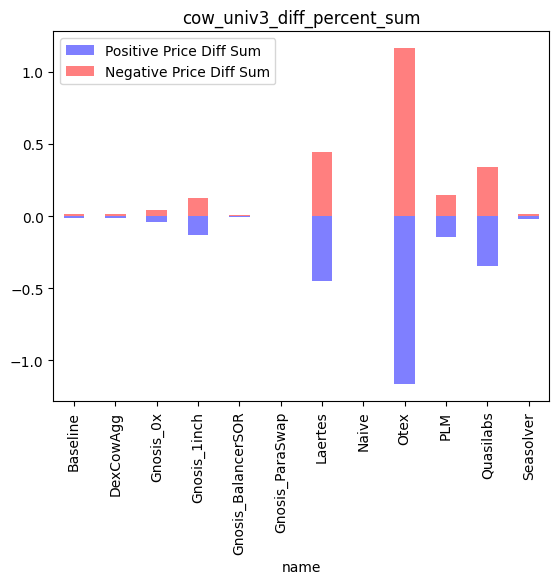

In [130]:
# plot histogram grouped by names showing the sum of the price diff
# price_diff_df_filtered_usdc.groupby('name')['cow_univ3_diff_percent'].sum().plot(kind='bar', title='cow_univ3_diff_percent')

# Create a Matplotlib figure and axis object
fig, ax = plt.subplots()

# Create two sets of data using the groupby method
pos_counts = price_diff_df_filtered_usdc.groupby('name')['cow_univ3_diff_percent'].sum()
neg_counts = -price_diff_df_filtered_usdc.groupby('name')['cow_univ3_diff_percent'].sum()

# Plot the first bar chart on the axis
pos_counts.plot(kind='bar', ax=ax, color='b', alpha=0.5, label='Positive Price Diff Sum')

# Plot the second bar chart on the same axis
neg_counts.plot(kind='bar', ax=ax, color='r', alpha=0.5, label='Negative Price Diff Sum')

# Add a legend to the plot
ax.legend()

# Set the title for the plot
ax.set_title('cow_univ3_diff_percent_sum (USDC)')

# Show the plot
plt.show()

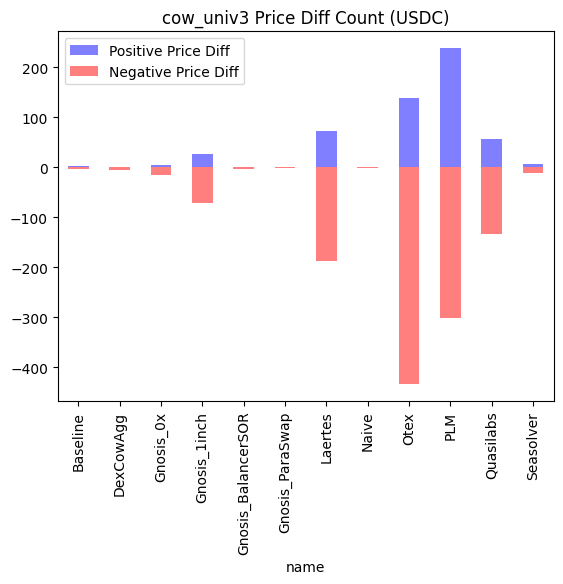

In [131]:
# Create a Matplotlib figure and axis object
fig, ax = plt.subplots()

# Create two sets of data using the groupby method
pos_counts = price_diff_df_filtered_usdc.groupby('name')['cow_univ3_diff_percent'].apply(lambda x: (x > 0).sum())
neg_counts = -price_diff_df_filtered_usdc.groupby('name')['cow_univ3_diff_percent'].apply(lambda x: (x < 0).sum())

# Plot the first bar chart on the axis
pos_counts.plot(kind='bar', ax=ax, color='b', alpha=0.5, label='Positive Price Diff')

# Plot the second bar chart on the same axis
neg_counts.plot(kind='bar', ax=ax, color='r', alpha=0.5, label='Negative Price Diff')

# Add a legend to the plot
ax.legend()

# Set the title for the plot
ax.set_title('cow_univ3 Price Diff Count (USDC)')

# Show the plot
plt.show()

In [136]:
# get new dataframe with only positive cow_univ3_diff_pct values
price_diff_df_filtered_usdc_pos = price_diff_df_filtered_usdc[price_diff_df_filtered_usdc['cow_univ3_diff_percent'] > 0]

Text(0.5, 1.0, 'USDC Price Diff, Positive')

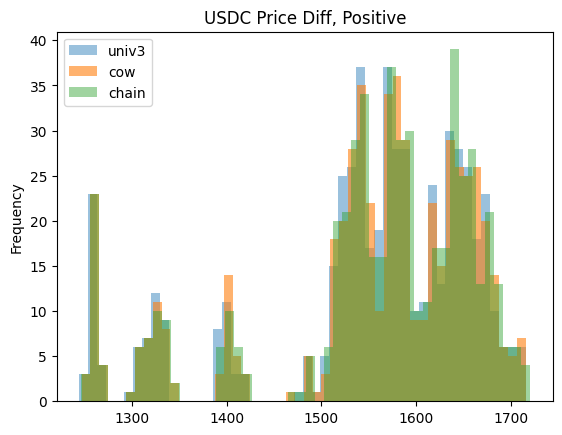

In [148]:
# plot the univ3, cow, and chain prices as histogram distributions with  matplotlib all on the same axis
fig, ax = plt.subplots()
price_diff_df_filtered_usdc_pos['univ3'].plot(kind='hist', bins=50, ax=ax, alpha=0.45, label='univ3')
price_diff_df_filtered_usdc_pos['cow'].plot(kind='hist', bins=50, ax=ax, alpha=0.6, label='cow')
price_diff_df_filtered_usdc_pos['chain'].plot(kind='hist', bins=50, ax=ax, alpha=0.45, label='chain')
ax.legend()

plt.title('USDC Price Diff, Positive')

In [140]:
# get new dataframe with only negative cow_univ3_diff_pct values
price_diff_df_filtered_usdc_neg = price_diff_df_filtered_usdc[price_diff_df_filtered_usdc['cow_univ3_diff_percent'] < 0]

Text(0.5, 1.0, 'USDC Price Diff, Negative')

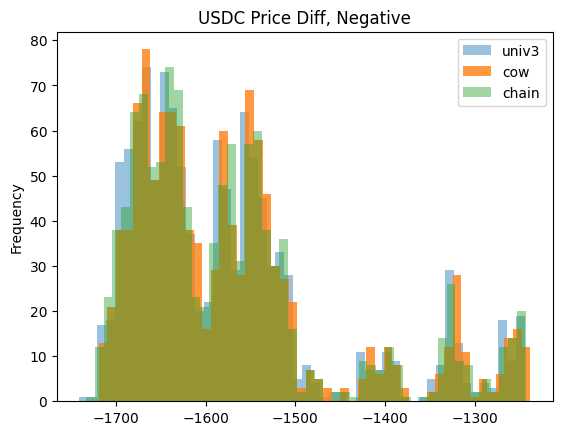

In [160]:
# plot the univ3, cow, and chain prices as histogram distributions with  matplotlib all on the same axis
fig, ax = plt.subplots()
price_diff_df_filtered_usdc_neg['univ3'].plot(kind='hist', bins=50, ax=ax, alpha=0.45, label='univ3')
price_diff_df_filtered_usdc_neg['cow'].plot(kind='hist', bins=50, ax=ax, alpha=0.8, label='cow')
price_diff_df_filtered_usdc_neg['chain'].plot(kind='hist', bins=50, ax=ax, alpha=0.45, label='chain')
ax.legend()

plt.title('USDC Price Diff, Negative')

In [181]:
# take the price_diff_df_filtered_usdc_pos dataframe and use it as a filter on execution_prices timestamp to get trade amount
sample = execution_prices_pd[execution_prices_pd.index.isin(price_diff_df_filtered_usdc_neg.index)]

In [182]:
sample

,swaps_blockNumber,trades_txHash,trades_gasPrice,trades_feeAmount,trades_sellToken_id,trades_buyToken_id,trades_sellAmount_converted,trades_buyAmount_converted,name,environment,swaps_pool_id,swaps_tokenIn_id,swaps_tokenOut_id,swaps_amountIn_converted,swaps_amountOut_converted,trades_buy_sell_ratio,trades_sell_buy_ratio,swaps_amountIn_amountOut_ratio,swaps_amountOut_amountIn_ratio,prices_assetPair_id,prices_price
trades_timestamp,,,,,,,,,,,,,,,,,,,,,
1.672876e+09,1.000000e-04,0x17bd696ae686e67409a158e59f2797e2ba83c4207e3f632cc5d8855f28726c54,2.094842e+10,3.430108e+15,WETH,USDC,3.600000,4513.725491,Otex,prod,None,None,None,0.000100,0.000100,1253.812636,1253.812636,10000.000000,10000.000000,None,0.0001
1.672876e+09,1.000000e-04,0x17bd696ae686e67409a158e59f2797e2ba83c4207e3f632cc5d8855f28726c54,2.094842e+10,3.430108e+15,WETH,USDC,3.600000,4513.725491,Otex,prod,None,None,None,0.000100,0.000100,1253.812636,1253.812636,10000.000000,10000.000000,None,0.0001
1.672883e+09,1.000000e-04,0xe77f89bf9bfab72ea3537694962c6077779f17bc0f4d1c1faee1c04b4b239e40,1.638723e+10,2.892302e+15,WETH,USDC,7.880170,9886.838153,PLM,prod,None,None,None,0.000100,0.000100,1254.647829,1254.647829,10000.000000,10000.000000,None,0.0001
1.672883e+09,1.000000e-04,0xe77f89bf9bfab72ea3537694962c6077779f17bc0f4d1c1faee1c04b4b239e40,1.638723e+10,2.892302e+15,WETH,USDC,7.880170,9886.838153,PLM,prod,None,None,None,0.000100,0.000100,1254.647829,1254.647829,10000.000000,10000.000000,None,0.0001
1.672885e+09,1.000000e-04,0x1e37b061b01f0330ac7bee0f654d54649876a42cc6dad784eb8a60ce4fc9f463,1.660040e+10,2.014423e+15,WETH,USDC,1.960000,2454.691313,Otex,prod,None,None,None,0.000100,0.000100,1252.393527,1252.393527,10000.000000,10000.000000,None,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.677165e+09,1.669188e+07,0x662d23ebfc1895cf24599f165df784506dd262fe7b44acc1fc771a0d7fc8447e,7.707062e+10,2.390684e+16,WETH,USDC,1.000000,1618.495660,Otex,prod,USDC_WETH .05%,WETH,USDC,139.502903,230589.985261,1618.495660,1618.495660,1652.940402,1652.940402,None,0.0001
1.677165e+09,1.669188e+07,0x662d23ebfc1895cf24599f165df784506dd262fe7b44acc1fc771a0d7fc8447e,7.707062e+10,2.390684e+16,WETH,USDC,1.000000,1618.495660,Otex,prod,USDC_WETH .05%,USDC,WETH,18986.268352,11.472585,1618.495660,1618.495660,1654.925052,1654.925052,None,0.0001
1.677165e+09,1.669188e+07,0x662d23ebfc1895cf24599f165df784506dd262fe7b44acc1fc771a0d7fc8447e,7.707062e+10,2.390684e+16,WETH,USDC,1.000000,1618.495660,Otex,prod,USDC_WETH .3%,WETH,USDC,73.875100,122116.182838,1618.495660,1618.495660,1653.008693,1653.008693,None,0.0001


Text(0.5, 1.0, 'buyToken=USDC, swaps_amountOut=USDC')

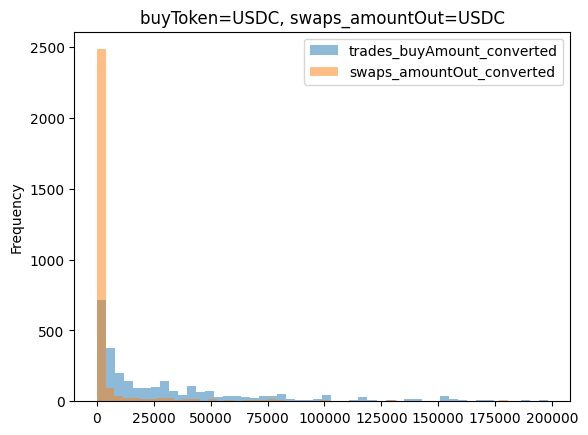

In [183]:
# plot the trades_buyAmount_converted, swaps_amountOut_converted to get a sense of the distribution. Cut off values greater than 1e6
sample[sample['trades_buyAmount_converted'] < 2e5]['trades_buyAmount_converted'].plot(kind='hist', bins=50, alpha=0.5, label='trades_buyAmount_converted')
sample[sample['swaps_amountOut_converted'] < 2e5]['swaps_amountOut_converted'].plot(kind='hist', bins=50, alpha=0.5, label='swaps_amountOut_converted')
plt.legend()

plt.title("buyToken=USDC, swaps_amountOut=USDC")

#### Aggregate Price Diff Stats

In [184]:
# sum the percent rows
usdc_univ3_sum = price_diff_df_filtered_usdc['cow_univ3_diff_percent'].sum()
usdc_chain_sum = price_diff_df_filtered_usdc['cow_chain_diff_percent'].sum()

# print the sums
print(f"usdc_univ3_sum: {usdc_univ3_sum}")
print(f"usdc_chain_sum: {usdc_chain_sum}")

usdc_univ3_sum: -2.3260288360159063
usdc_chain_sum: -2.47414135125344


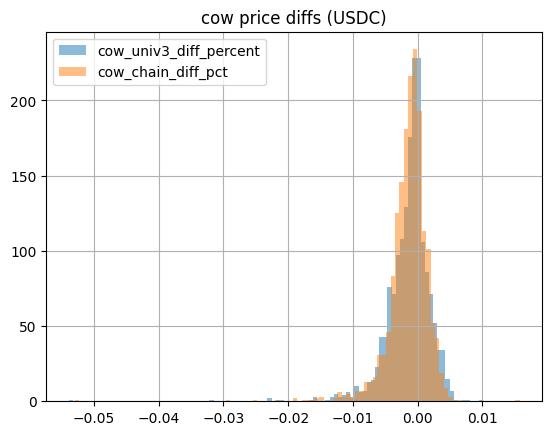

In [185]:
# plot histograms of the percent differences
price_diff_df_filtered_usdc['cow_univ3_diff_percent'].hist(bins=100, label='cow_univ3_diff_percent', alpha=.5)
price_diff_df_filtered_usdc['cow_chain_diff_percent'].hist(bins=100, label='cow_chain_diff_pct', alpha=.5)

plt.title('cow price diffs (USDC)')
plt.legend()
plt.show();

In [101]:
# sum the percent rows
weth_univ3_sum = price_diff_df_filtered_weth['cow_univ3_diff_percent'].sum()
weth_chain_sum = price_diff_df_filtered_weth['cow_chain_diff_percent'].sum()

# print the sums
print(f"weth_univ3_sum: {weth_univ3_sum}")
print(f"weth_chain_sum: {weth_chain_sum}")

weth_univ3_sum: 0.4702847380012414
weth_chain_sum: 0.5829106608509375


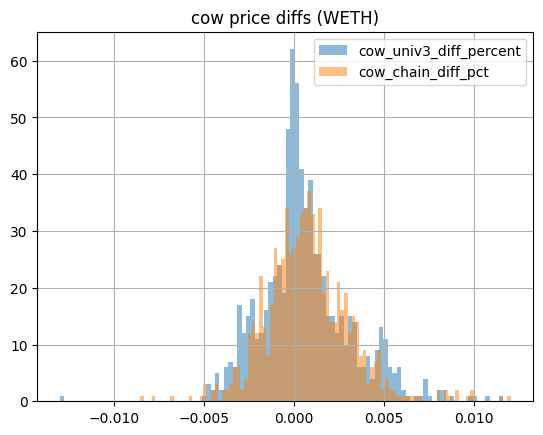

In [100]:
# plot histograms of the percent differences
price_diff_df_filtered_weth['cow_univ3_diff_percent'].hist(bins=100, label='cow_univ3_diff_percent', alpha=.5)
price_diff_df_filtered_weth['cow_chain_diff_percent'].hist(bins=100, label='cow_chain_diff_pct', alpha=.5)

plt.title('cow price diffs (WETH)')
plt.legend()
plt.show();

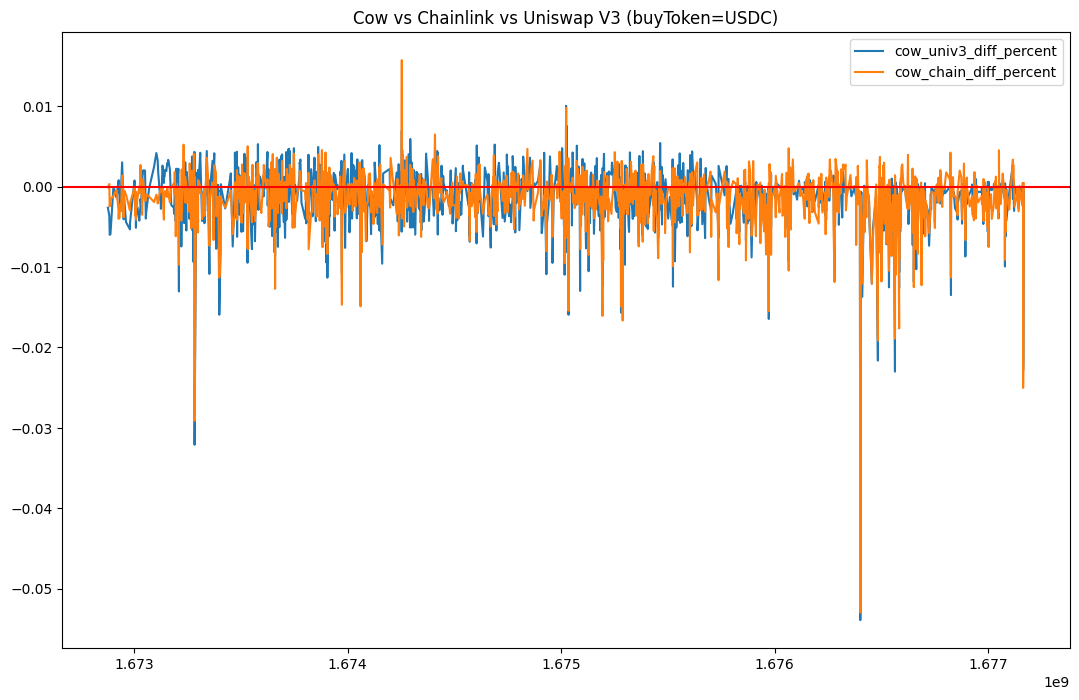

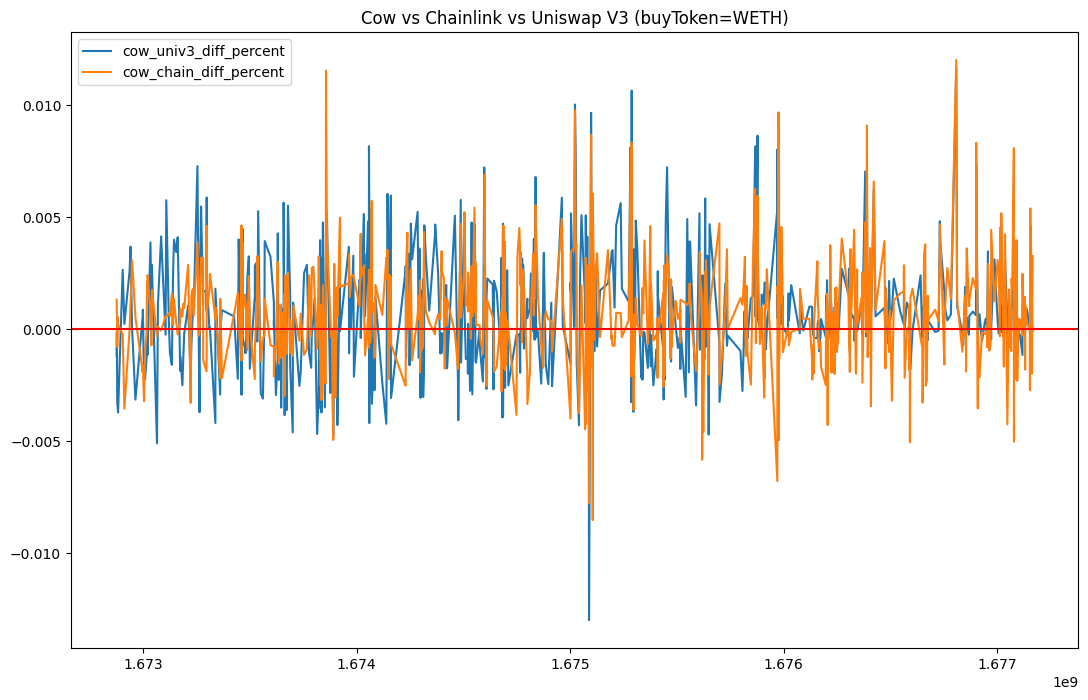

In [88]:
# plot the percent columns filtered data in same plot axis, add horizontal line at 0
price_diff_df_filtered_usdc[['cow_univ3_diff_percent', 'cow_chain_diff_percent']].plot(figsize=(13,8), title='Cow vs Chainlink vs Uniswap V3 (buyToken=USDC)')
plt.axhline(y=0, color='r', linestyle='-')
price_diff_df_filtered_weth[['cow_univ3_diff_percent', 'cow_chain_diff_percent']].plot(figsize=(13,8), title='Cow vs Chainlink vs Uniswap V3 (buyToken=WETH)')
plt.axhline(y=0, color='r', linestyle='-')

In [89]:
STOP

NameError: name 'STOP' is not defined

#### Plot Prices side by side (without ffill)

In [ ]:
# cut the univ3_execution_prices_pd to begin when CoW Data begins
univ3_execution_prices_pd = univ3_execution_prices_pd[univ3_execution_prices_pd.index >= cow_execution_prices_pd.index[0]]

In [ ]:
# get the minimum index value for the Univ3 data as a sanity check. This is the starting block.
univ3_execution_prices_pd[univ3_execution_prices_pd.index > cow_execution_prices_pd.index.min()]['swaps_amountIn_amountOut_ratio'].index.min()

1676272799.0

In [ ]:
# merge cow and univ3
cow_univ3_execution_prices_pd = cow_execution_prices_pd.merge(univ3_execution_prices_pd, left_index=True, right_index=True, how='inner')
cow_univ3_chain_execution_prices_pd = cow_univ3_execution_prices_pd.merge(chain_execution_prices_pd, left_index=True, right_index=True, how='inner')

In [ ]:
cow_color = '#ff7f0e'
univ3_color = '#1f77b4'
chain_color = '#2ca02c'

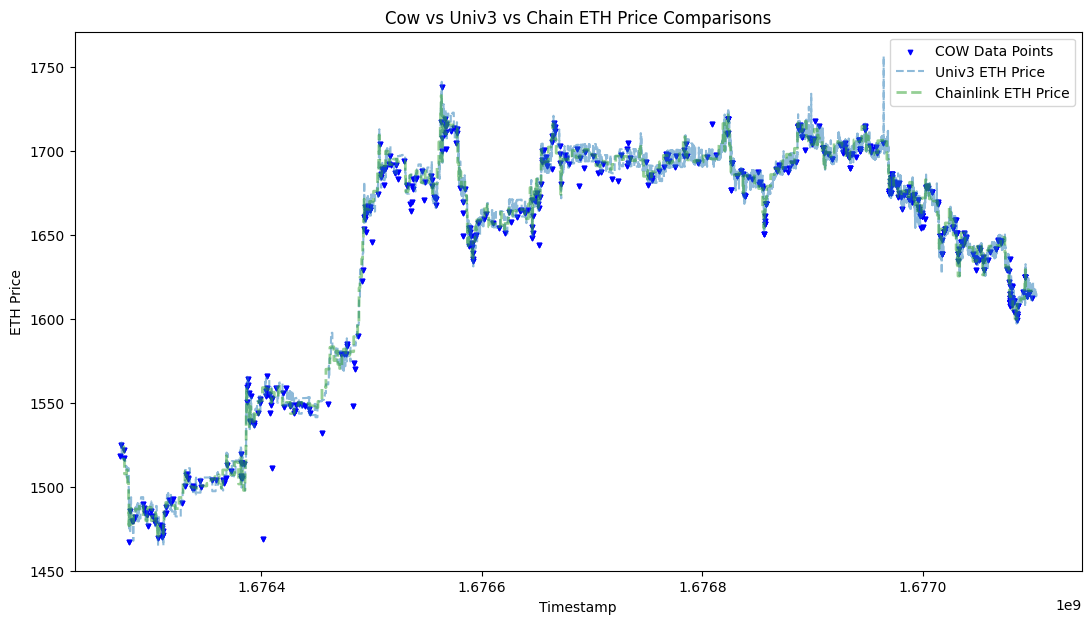

cow_execution_prices_pd shape: (1186, 21)
univ3_execution_prices_pd shape: (25157, 21)
chain_execution_prices_pd shape: (562, 21)


In [ ]:
plt.figure(figsize=(13,7))

# emphasize CoW price points
plt.scatter(cow_execution_prices_pd.index, cow_execution_prices_pd['trades_buy_sell_ratio'], color='blue', label='COW Data Points', marker="v", s=10)

# plot step prices of cow, univ3, and chain
plt.step(univ3_execution_prices_pd.index, univ3_execution_prices_pd['swaps_amountIn_amountOut_ratio'], label='Univ3 ETH Price', color=univ3_color, linestyle='dashed', alpha=.5)
plt.step(chain_execution_prices_pd.index, chain_execution_prices_pd['prices_price'], label='Chainlink ETH Price', color=chain_color, linestyle='dashed', linewidth=2, alpha=.5)


plt.title('Cow vs Univ3 vs Chain ETH Price Comparisons')
plt.xlabel('Timestamp')
plt.ylabel('ETH Price')
plt.legend(loc='best')
plt.show();

# print the shapes as f strings
print(f"cow_execution_prices_pd shape: {cow_execution_prices_pd.shape}")
print(f"univ3_execution_prices_pd shape: {univ3_execution_prices_pd.shape}")
print(f"chain_execution_prices_pd shape: {chain_execution_prices_pd.shape}")

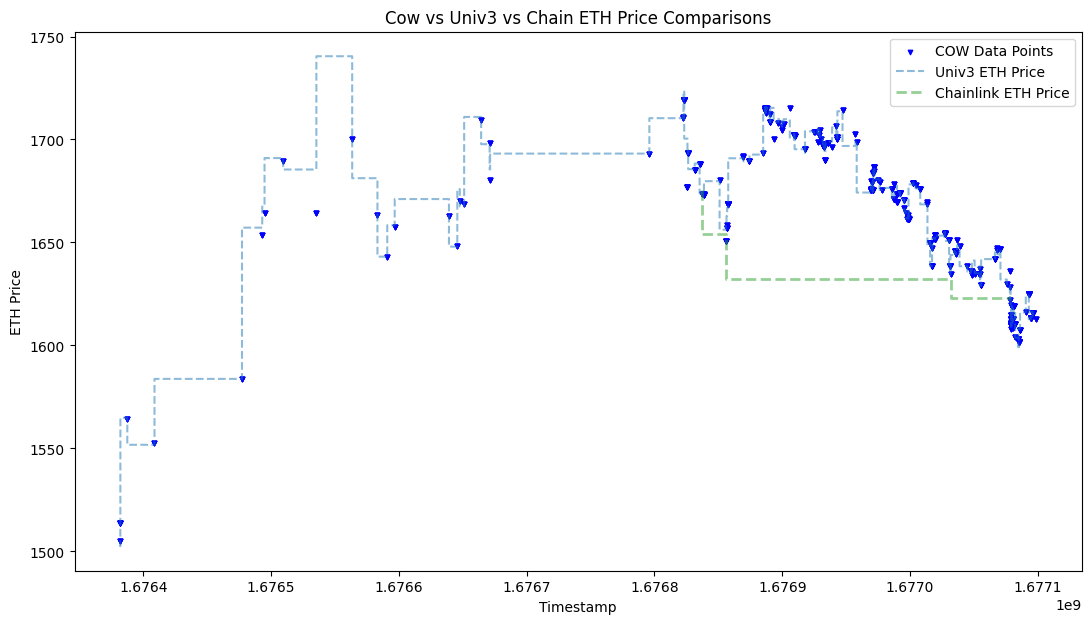

cow_univ3_execution_prices_pd shape: (2516, 42)
cow_univ3_chain_execution_prices_pd shape: (88, 63)


In [ ]:
plt.figure(figsize=(13,7))

# emphasize CoW price points
plt.scatter(cow_univ3_execution_prices_pd.index, cow_univ3_execution_prices_pd['trades_buy_sell_ratio_x'], color='blue', label='COW Data Points', marker="v", s=10)

# plot step prices of cow, univ3, and chain
plt.step(cow_univ3_execution_prices_pd.index, cow_univ3_execution_prices_pd['swaps_amountIn_amountOut_ratio_y'], label='Univ3 ETH Price', color=univ3_color, linestyle='dashed', alpha=.5)
plt.step(cow_univ3_chain_execution_prices_pd.index, cow_univ3_chain_execution_prices_pd['prices_price_x'], label='Chainlink ETH Price', color=chain_color, linestyle='dashed', linewidth=2, alpha=.5)


plt.title('Cow vs Univ3 vs Chain ETH Price Comparisons')
plt.xlabel('Timestamp')
plt.ylabel('ETH Price')
plt.legend(loc='best')
plt.show();


# print the shapes as f strings
print(f"cow_univ3_execution_prices_pd shape: {cow_univ3_execution_prices_pd.shape}")
print(f"cow_univ3_chain_execution_prices_pd shape: {cow_univ3_chain_execution_prices_pd.shape}")

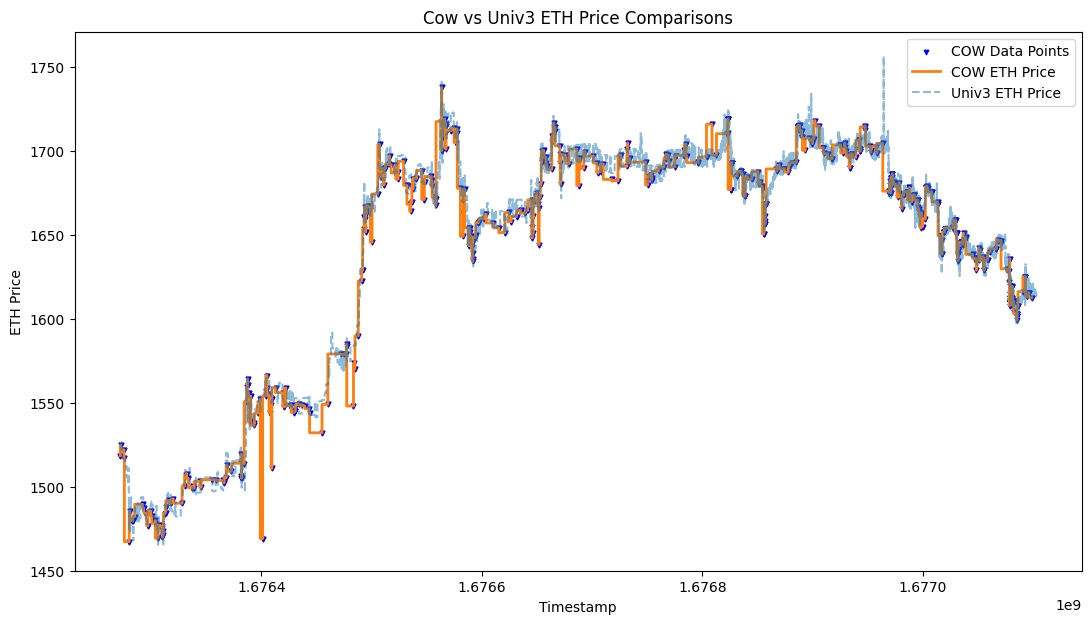

In [ ]:
plt.figure(figsize=(13,7))

# emphasize CoW price points
plt.scatter(cow_execution_prices_pd.index, cow_execution_prices_pd['trades_buy_sell_ratio'], color='blue', label='COW Data Points', marker="v", s=10)
plt.step(cow_execution_prices_pd.index, cow_execution_prices_pd['trades_buy_sell_ratio'], color=cow_color, label='COW ETH Price', linewidth=2)
plt.step(univ3_execution_prices_pd.index, univ3_execution_prices_pd['swaps_amountIn_amountOut_ratio'], label='Univ3 ETH Price', color=univ3_color, linestyle='dashed', alpha=.5)
# plt.step(chain_execution_prices_pd.index, chain_execution_prices_pd['prices_price'], label='Chainlink ETH Price', color='green', linestyle='dashed', linewidth=2, alpha=.5)


plt.title('Cow vs Univ3 ETH Price Comparisons')
plt.xlabel('Timestamp')
plt.ylabel('ETH Price')
plt.legend(loc='best')
plt.show();

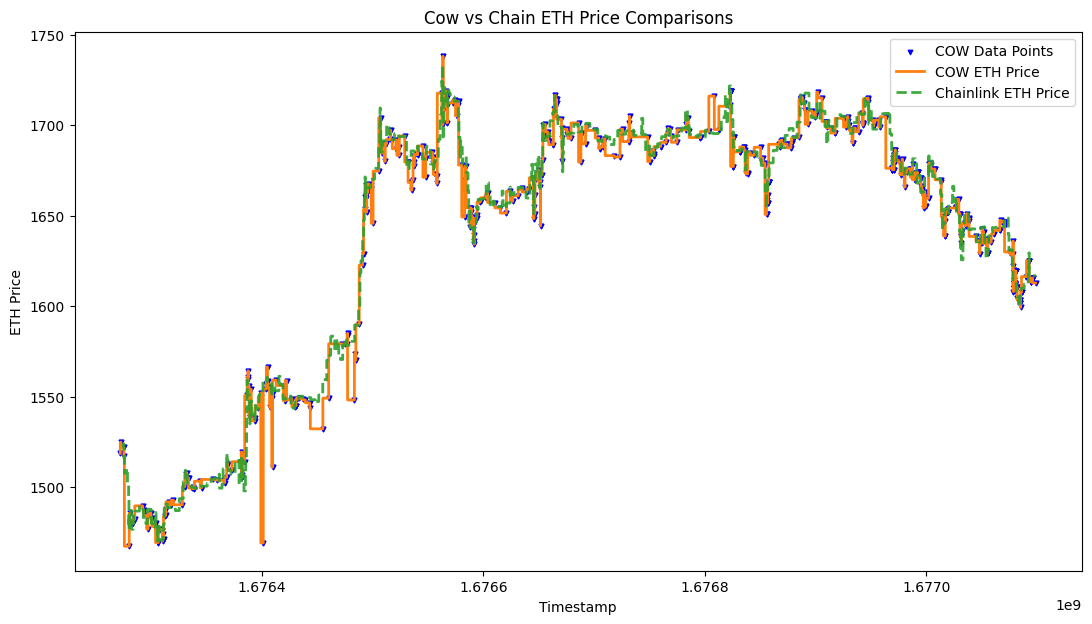

In [ ]:
plt.figure(figsize=(13,7))

# emphasize CoW price points
plt.scatter(cow_execution_prices_pd.index, cow_execution_prices_pd['trades_buy_sell_ratio'], color='blue', label='COW Data Points', marker="v", s=10)
plt.step(cow_execution_prices_pd.index, cow_execution_prices_pd['trades_buy_sell_ratio'], color=cow_color, label='COW ETH Price', linewidth=2)
plt.step(chain_execution_prices_pd.index, chain_execution_prices_pd['prices_price'], label='Chainlink ETH Price', color=chain_color, linestyle='dashed', linewidth=2, alpha=.9)


plt.title('Cow vs Chain ETH Price Comparisons')
plt.xlabel('Timestamp')
plt.ylabel('ETH Price')
plt.legend(loc='best')
plt.show();

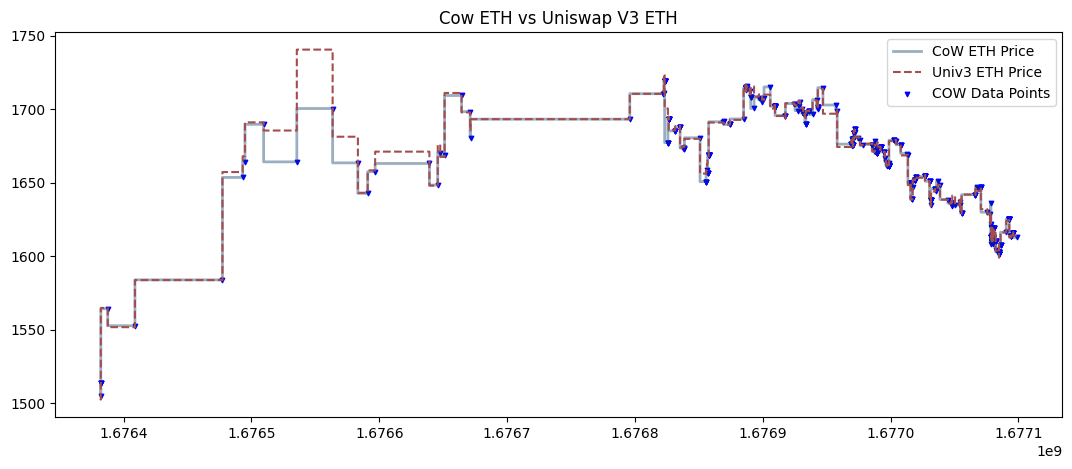

In [ ]:
plt.figure(figsize=(13,5))
# plot the above as a step plot and specify the colors 003664, 00203B
plt.step(cow_univ3_execution_prices_pd.index, cow_univ3_execution_prices_pd['trades_buy_sell_ratio_x'], label='CoW ETH Price', color='#003664', linewidth=2, alpha=0.4)
plt.step(cow_univ3_execution_prices_pd.index, cow_univ3_execution_prices_pd['swaps_amountIn_amountOut_ratio_y'], label='Univ3 ETH Price', color='#a34d4d', linestyle='dashed')

plt.scatter(cow_univ3_execution_prices_pd.index, cow_univ3_execution_prices_pd['trades_buy_sell_ratio_x'], color='blue', label='COW Data Points', marker="v", s=10)
# plt.scatter(cow_univ3_execution_prices_pd.index, cow_univ3_execution_prices_pd['swaps_amountIn_amountOut_ratio_y'], color='blue', marker="^", s=5)


plt.title('Cow ETH vs Uniswap V3 ETH')
plt.legend()
plt.show();

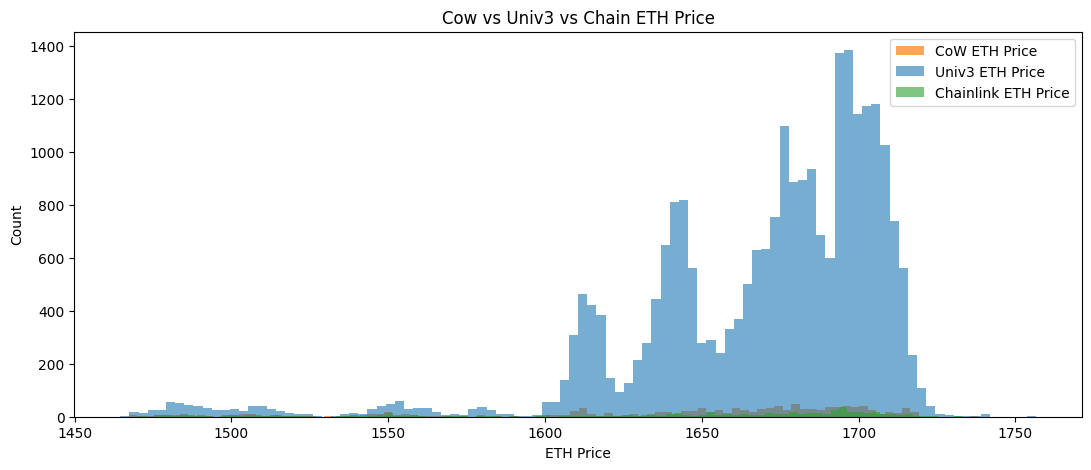

In [ ]:
# plot histogram distributions of the above and normalize the values
plt.figure(figsize=(13,5))
plt.hist(cow_execution_prices_pd['trades_buy_sell_ratio'], bins=100, label='CoW ETH Price', color=cow_color, alpha=0.7)
plt.hist(univ3_execution_prices_pd['swaps_amountIn_amountOut_ratio'], bins=100, label='Univ3 ETH Price', color=univ3_color, alpha=0.6)
plt.hist(chain_execution_prices_pd['prices_price'], bins=100, label='Chainlink ETH Price', color=chain_color, alpha=0.6)

plt.title('Cow vs Univ3 vs Chain ETH Price')
plt.xlabel('ETH Price')
plt.ylabel('Count')
plt.legend()
plt.show();

In [ ]:
# count how many points are plotted
cow_univ3_execution_prices_pd['trades_buy_sell_ratio_x'].count()

629

### OLD

In [ ]:
# get the rows that have 0 null values. This leaves us with the cow/univ3 trades that were executed on the same timestamp.
cow_uni_trunc_no_nulls_pl = cow_uni_trunc_pl.drop_nulls()

In [ ]:
# check shape.
cow_uni_trunc_no_nulls_pl.shape

In [ ]:
# drop duplicate row values polars dataframe. Note - Unsure why duplicates get inserted into the dataframe during the transformation
cow_uni_trunc_no_nulls_pl = cow_uni_trunc_no_nulls_pl.unique()

In [ ]:
cow_uni_trunc_no_nulls_pl.shape

In [ ]:
# how many values in trades_feeAmount are 0 polars series
cow_uni_trunc_no_nulls_pl['trades_feeAmount'].eq(0).sum()

In [ ]:
cow_uni_trunc_no_nulls_pl.head(15)

#### Add Decimal Values to data

In [ ]:
# add decimals to cow trades sell tokens
cow_uni_trunc_no_nulls_pl = cow_uni_trunc_no_nulls_pl.with_columns(
    [
        pl.col('trades_sellToken_id'),
        (
            pl.when(pl.col('trades_sellToken_id') == 'WETH')
            .then(18)
            .otherwise(6)
            .cast(pl.UInt8)
        ).alias('trades_sellToken_decimals'),
    ]
)

# add decimals to cow trades buy tokens
cow_uni_trunc_no_nulls_pl = cow_uni_trunc_no_nulls_pl.with_columns(
    [
        pl.col('trades_buyToken_id'),
        (
            pl.when(pl.col('trades_buyToken_id') == 'WETH')
            .then(18)
            .otherwise(6)
            .cast(pl.UInt8)
        ).alias('trades_buyToken_decimals'),
    ]
)

In [ ]:
# add decimals to cow trades sell tokens
cow_uni_trunc_no_nulls_pl = cow_uni_trunc_no_nulls_pl.with_columns(
    [
        pl.col('swaps_tokenIn_id'),
        (
            pl.when(pl.col('swaps_tokenIn_id') == 'WETH')
            .then(18)
            .otherwise(6)
            .cast(pl.UInt8)
        ).alias('swaps_tokenIn_decimals'),
    ]
)

# add decimals to cow trades buy tokens
cow_uni_trunc_no_nulls_pl = cow_uni_trunc_no_nulls_pl.with_columns(
    [
        pl.col('swaps_tokenOut_id'),
        (
            pl.when(pl.col('swaps_tokenOut_id') == 'WETH')
            .then(18)
            .otherwise(6)
            .cast(pl.UInt8)
        ).alias('swaps_tokenOut_decimals'),
    ]
)

In [ ]:
# note that polars can perform these calculations in-column. This means it can convert the values in place without creating a new column. The new column created here is more verbose, but is a good sanity check to see before/after results.
trades_swaps_converted_pl = cow_uni_trunc_no_nulls_pl.with_columns([
    (pl.col("trades_buyAmount") / (10**pl.col("trades_buyToken_decimals"))).alias('trades_buyAmount_converted'),
    (pl.col("trades_sellAmount") / (10**pl.col("trades_sellToken_decimals"))).alias('trades_sellAmount_converted'),
    (pl.col("swaps_amountIn") / (10**pl.col("swaps_tokenIn_decimals"))).alias('swaps_amountIn_converted'),
    (pl.col("swaps_amountOut") / (10**pl.col("swaps_tokenOut_decimals"))).alias('swaps_amountOut_converted'),
])

In [ ]:
# check that the decimal columns and conversion columns were added
trades_swaps_converted_pl.columns

In [ ]:
trades_swaps_converted_trunc_pl = trades_swaps_converted_pl[
    'trades_timestamp',
    'swaps_blockNumber',
    'trades_sellToken_id',
    'trades_buyToken_id',
    'trades_sellAmount_converted',
    'trades_buyAmount_converted',
    'name',
    'environment',
    'swaps_pool_id',
    'swaps_tokenIn_id',
    'swaps_tokenOut_id',
    'swaps_amountIn_converted',
    'swaps_amountOut_converted',
]

### Add Execution Price Columns "x/y" and "y/x"

We calculate execution prices for cow trades and univ3 swaps. Then we take the timestamp with the most number of executions and compare the execution prices.

In [ ]:
trades_swaps_converted_trunc_pl = trades_swaps_converted_trunc_pl.with_columns([
    (pl.col("trades_buyAmount_converted") / pl.col("trades_sellAmount_converted")).alias('trades_buy_sell_ratio'),
    (pl.col("trades_sellAmount_converted") / pl.col("trades_buyAmount_converted")).alias('trades_sell_buy_ratio'),
    (pl.col("swaps_amountIn_converted") / pl.col("swaps_amountOut_converted")).alias('swaps_amountIn_amountOut_ratio'),
    (pl.col("swaps_amountOut_converted") / pl.col("swaps_amountIn_converted")).alias('swaps_amountOut_amountIn_ratio'),
])

In [ ]:
# plot Cow ETH price vs Univ3 ETH price
trades_swaps_converted_trunc_pl.head(5)


In [ ]:
# filter for the columns trades_timestamp, swaps_blockNumber, trades_buy_sell_ratio, trades_sell_buy_ratio, swaps_amountIn_amountOut_ratio, swaps_amountOut_amountIn_ratio
execution_prices_pl = trades_swaps_converted_trunc_pl[
    'trades_timestamp',
    'swaps_blockNumber',
    'trades_buy_sell_ratio',
    'trades_sell_buy_ratio',
    'swaps_amountIn_amountOut_ratio',
    'swaps_amountOut_amountIn_ratio',
]

In [ ]:
# return the larger value between trades_buy_sell_ratio and trades_sell_buy_ratio in a lambda function
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buy_sell_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_buy_sell_ratio'),
    (pl.col("trades_sell_buy_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_sell_buy_ratio'),
    (pl.col("swaps_amountIn_amountOut_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountIn_amountOut_ratio'),
    (pl.col("swaps_amountOut_amountIn_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountOut_amountIn_ratio'),
])

In [ ]:
# convert execution_prices_pl to pandas dataframe
execution_prices_pd = execution_prices_pl.to_pandas()

In [ ]:
execution_prices_pd.head(5)

In [ ]:
# set trades_timestamp as index and order by trades_timestamp
execution_prices_pd = execution_prices_pd.set_index('trades_timestamp').sort_index()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# plot trades_buy_sell_ratio and swaps_amountIn_amountOut_ratio and change legend labels
execution_prices_pd[['trades_buy_sell_ratio', 'swaps_amountIn_amountOut_ratio']].plot()

# change legend labels
plt.legend(['Cow ETH price', 'Univ3 ETH price'])

#### Largest Block Activity Analysis

In [ ]:
# find the juiciest timestamp with the most amount of activity
trades_swaps_converted_trunc_pl['trades_timestamp'].value_counts().sort('counts', reverse=True)

In [ ]:
# get timestamp value with highest count
biggest_timestamp_count = trades_swaps_converted_trunc_pl['trades_timestamp'].value_counts().sort('counts', reverse=True).head(1)

In [ ]:
biggest_timestamp_count

In [ ]:
biggest_timestamp_count_int = biggest_timestamp_count['trades_timestamp'].head(1).to_numpy()[0]

In [ ]:
# filter poalrs dataframe by 1676823287 timestamp value
filter_trades_swaps_pl = trades_swaps_converted_trunc_pl.filter(pl.col('trades_timestamp') == biggest_timestamp_count_int)

In [ ]:
filter_trades_swaps_pl

In [ ]:
print(f'At timestamp {biggest_timestamp_count_int}, there were {filter_trades_swaps_pl.shape[0]} trades and swaps.')

print(f'\
Cow mean execution prices were {filter_trades_swaps_pl["trades_buy_sell_ratio"].mean()} \
and {filter_trades_swaps_pl["trades_sell_buy_ratio"].mean()} \
completed by solver {filter_trades_swaps_pl["name"].head(1).to_numpy()[0]}')

print(f'\
The Univ3 pool {filter_trades_swaps_pl["swaps_pool_id"].head(1).to_numpy()[0]} mean execution price during this time was {filter_trades_swaps_pl["swaps_amountOut_amountIn_ratio"].mean()} \
and {filter_trades_swaps_pl["swaps_amountIn_amountOut_ratio"].mean()}')


### Save Dataset to Csv

In [ ]:
# save cow_complete_pl to csv
trades_swaps_converted_trunc_pl.write_csv('data/trades_swaps_converted_trunc_pl.csv')